In [1]:
import xarray as xr
from eofs.xarray import Eof
import numpy as np
import pandas as pd
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.stats import pearsonr
import climtas.io
from statsmodels.tsa import tsatools

### Data 

In [12]:
# Open HadISST 
sst_ds = xr.open_dataset('/g/data/w40/rl5183/hadisst.1870_2017_1.5x1.5.nc')
sst = sst_ds.sst.sel(lat=slice(-30,30)).sel(lon=slice(120,270)).sel(time=slice('1900-01', '2014-12'))
# Detrend 
sst_detrend = np.apply_along_axis(func.detrend_2step, 0, sst)
sst_dt = xr.DataArray(sst_detrend, coords=sst.coords, attrs=sst.attrs)

In [3]:
# Calculate Nino34 index
nino34 = func.nino34_index(sst_dt, '1979-01', '2008-12')
# Calculate monthly anomalies 
clim = sst_dt.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anom = sst_dt.groupby('time.month') - clim
# Calculate EOFs
eof, pcs, var = func.eof_and_pcs(anom, 2)

In [2]:
# Global temperature and rainfall data 
# NCEP/NCAR reanalysis 
ts = xr.open_dataset('/g/data/w40/rl5183/NCEP_NCAR_reanalysis/air.mon.mean.nc').air.sel(time=slice('1948-01', '2014-12'))
pr = xr.open_dataset('/g/data/w40/rl5183/NCEP_NCAR_reanalysis/pr_wtr.mon.mean.nc').pr_wtr.sel(time=slice('1948-01', '2014-12'))

In [3]:
# Detrend ts 
ts_detrend = np.apply_along_axis(func.quad_detrend, 0, ts)
ts_dt = xr.DataArray(ts_detrend, coords=ts.coords, attrs=ts.attrs)

In [6]:
# Calculate EOFs over tropical pacific region

# Select out region
#ts_tp = ts.sel(lat=slice(30,-30)).sel(lon=slice(120,270))
# APPLY LANDMASK
# Calculate monthly anomalies 
#clim = ts_tp.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
#anom = ts_tp.groupby('time.month') - clim
# Calculate EOFs
#eof, pcs, var = func.eof_and_pcs(anom, 2)

# Calculate Nino34 index
#nino34 = func.nino34_index(ts_dt, '1979-01', '2008-12')

### El Nino and La Nina 

In [5]:
# El Nino, La Nina years 

# Using SST method 
el_nino_years_sst, la_nina_years_sst = func.find_event_years(nino34, 0.4, 6)

# Using EOF method 

# Normalise pcs
pc1 = pcs.sel(mode=1)*(-1)
std1 = pc1.std() # Takhashi usues standrd deviatuion of base period 
pc1 = pc1/std1

# Methods from Perry et. al 2020 - normalised PC1 amplitude exceeds +/- 0.75
func.seasonyear(pc1)
seasonal_pc1 = pc1.groupby('seasonyear').apply(func.seasonal_mean)
djf_pc1 = seasonal_pc1.sel(season='DJF')
el_nino_years_eof = djf_pc1.where(djf_pc1>0.75, drop=True).seasonyear
la_nina_years_eof = djf_pc1.where(djf_pc1<-0.75, drop=True).seasonyear
# Remeber to minus 1 when printing out years as december is pushed over to next year 

In [6]:
# Make years match reanalysis years
nino34 = nino34.sel(time=slice('1948-01', '2014-12'))
el_nino_years_eof = el_nino_years_eof.sel(seasonyear=slice(1948, 2014))
la_nina_years_eof = la_nina_years_eof.sel(seasonyear=slice(1948, 2014))

In [7]:
# El Nino, La Nina composites 

# Using SST method 
el_nino_comp_ts, la_nina_comp_ts = func.sst_comp(nino34, ts, 'DJF')
el_nino_comp_pr, la_nina_comp_pr = func.sst_comp(nino34, pr, 'DJF')

# Using EOF method
# Add season year axis to sst data 
func.seasonyear(ts)
func.seasonyear(pr)
# Calculate seasonal means 
seasonal_ts = ts.groupby('seasonyear').apply(func.seasonal_mean)
seasonal_pr = pr.groupby('seasonyear').apply(func.seasonal_mean)
# Select out season
ts_djf = seasonal_ts.sel(season='DJF')
pr_djf = seasonal_pr.sel(season='DJF')
# Find composite 
el_nino_comp_eof_ts = (ts_djf.sel(seasonyear=el_nino_years_eof) - ts_djf.mean(dim='seasonyear')).mean(dim='seasonyear')
la_nina_comp_eof_ts = (ts_djf.sel(seasonyear=la_nina_years_eof) - ts_djf.mean(dim='seasonyear')).mean(dim='seasonyear')
el_nino_comp_eof_pr = (pr_djf.sel(seasonyear=el_nino_years_eof) - pr_djf.mean(dim='seasonyear')).mean(dim='seasonyear')
la_nina_comp_eof_pr = (pr_djf.sel(seasonyear=la_nina_years_eof) - pr_djf.mean(dim='seasonyear')).mean(dim='seasonyear')

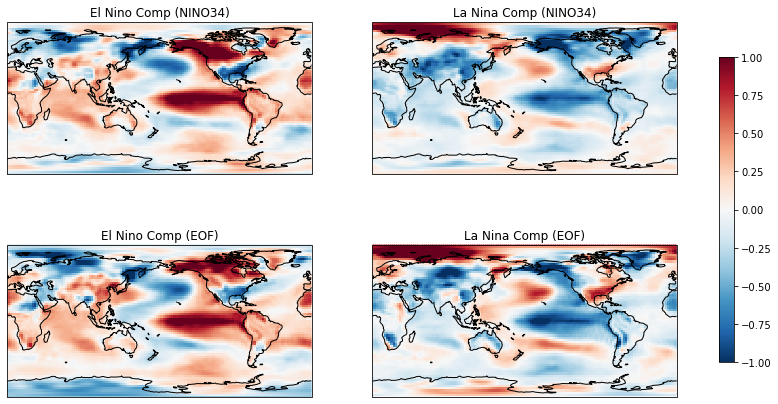

In [8]:
fig = plt.figure(figsize = (15,7.5)) 
axs = []
ax = fig.add_subplot(221, projection=ccrs.PlateCarree(180))
im = el_nino_comp_ts.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Nino Comp (NINO34)')
axs.append(ax)
ax = fig.add_subplot(222, projection=ccrs.PlateCarree(180))
im = la_nina_comp_ts.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Nina Comp (NINO34)')
axs.append(ax)
ax = fig.add_subplot(223, projection=ccrs.PlateCarree(180))
im = el_nino_comp_eof_ts.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Nino Comp (EOF)')
axs.append(ax)
ax = fig.add_subplot(224, projection=ccrs.PlateCarree(180))
im = la_nina_comp_eof_ts.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Nina Comp (EOF)')
axs.append(ax)
cbar = plt.colorbar(im, ax=axs, shrink=0.75, pad=0.05)
plt.savefig('enso_comp_nino34_eof_ts_NCEP_NCAR.jpg', bbox_inches='tight', dpi=300)

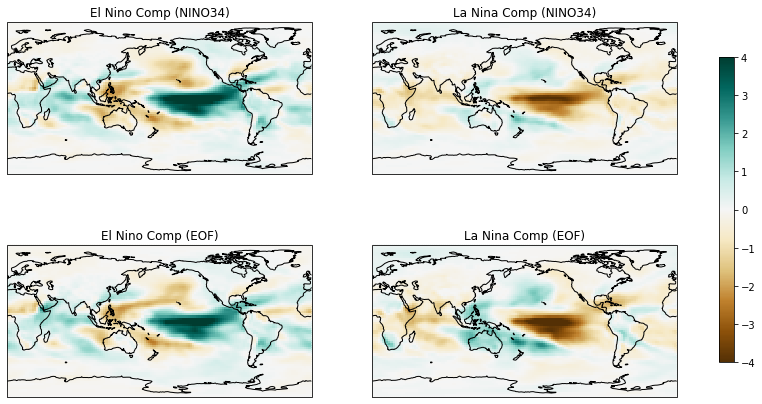

In [9]:
fig = plt.figure(figsize = (15,7.5)) 
axs = []
ax = fig.add_subplot(221, projection=ccrs.PlateCarree(180))
im = el_nino_comp_pr.plot(ax=ax, vmin=-4, vmax=4, cmap='BrBG', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Nino Comp (NINO34)')
axs.append(ax)
ax = fig.add_subplot(222, projection=ccrs.PlateCarree(180))
im = la_nina_comp_pr.plot(ax=ax, vmin=-4, vmax=4, cmap='BrBG', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Nina Comp (NINO34)')
axs.append(ax)
ax = fig.add_subplot(223, projection=ccrs.PlateCarree(180))
im = el_nino_comp_eof_pr.plot(ax=ax, vmin=-4, vmax=4, cmap='BrBG', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Nino Comp (EOF)')
axs.append(ax)
ax = fig.add_subplot(224, projection=ccrs.PlateCarree(180))
im = la_nina_comp_eof_pr.plot(ax=ax, vmin=-4, vmax=4, cmap='BrBG', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Nina Comp (EOF)')
axs.append(ax)
cbar = plt.colorbar(im, ax=axs, shrink=0.75, pad=0.05)
plt.savefig('enso_comp_nino34_eof_pr_NCEP_NCAR.jpg', bbox_inches='tight', dpi=300)

In [10]:
def comp_pattern_cor(comp1, comp2):
    # Make 1D
    comp1_1d = comp1.values.flatten()
    comp2_1d = comp2.values.flatten()
    # Mask
    comp1_1d = comp1_1d[np.isfinite(comp1_1d)]
    comp2_1d = comp2_1d[np.isfinite(comp2_1d)]
    # Correlation
    return pearsonr(comp1_1d, comp2_1d)

In [11]:
el_nino_cor_ts = comp_pattern_cor(el_nino_comp_ts, el_nino_comp_eof_ts)
la_nina_cor_ts = comp_pattern_cor(la_nina_comp_ts, la_nina_comp_eof_ts)
el_nino_cor_pr = comp_pattern_cor(el_nino_comp_pr, el_nino_comp_eof_pr)
la_nina_cor_pr = comp_pattern_cor(la_nina_comp_pr, la_nina_comp_eof_pr)

In [12]:
print(f'El Nino Corr ts: {el_nino_cor_ts[0]}, La Nina Corr ts: {la_nina_cor_ts[0]}')
print(f'El Nino Corr pr: {el_nino_cor_pr[0]}, La Nina Corr pr: {la_nina_cor_pr[0]}')

El Nino Corr ts: 0.829132571858065, La Nina Corr ts: 0.8774280651018613
El Nino Corr pr: 0.959886750680547, La Nina Corr pr: 0.9111853979136675


### EP and CP

In [13]:
# EP, CP years 

# Nino indices method
# Calculate Nino3 and Nino4
nino3 = func.nino3_index(sst_dt, '1979-01', '2008-12')
nino4 = func.nino4_index(sst_dt, '1979-01', '2008-12')
# Calculate EP and CP index
EP_sst = nino3 - 0.5*nino4
CP_sst = nino4 - 0.5*nino3
# Get EP and CP years 
seasonal_EP_sst = func.seasonal_mean_nino_index(EP_sst)
seasonal_CP_sst = func.seasonal_mean_nino_index(CP_sst)
djf_EP_sst = seasonal_EP_sst.sel(season='DJF')
djf_CP_sst = seasonal_CP_sst.sel(season='DJF')
EP_years_sst = djf_EP_sst.where(djf_EP_sst>0.5, drop=True)
CP_years_sst = djf_CP_sst.where(djf_CP_sst>0.5, drop=True)

In [14]:
# Normalise pc2
pc2 = pcs.sel(mode=2)
std2 = pc2.std()
pc2 = pc2/std2
# Seasonal index 
func.seasonyear(pc2)
seasonal_pc2 = pc2.groupby('seasonyear').apply(func.seasonal_mean)
djf_pc2 = seasonal_pc2.sel(season='DJF')

In [15]:
# E-index and C-index from Takahashi et al. 
E = (djf_pc1 - djf_pc2)/np.sqrt(2)
C = (djf_pc1 + djf_pc2)/np.sqrt(2)
# Get years 
E_years = E.where((E>1) & (E>C), drop=True)
C_years = C.where((C>0.8) & (C>E), drop=True)

In [16]:
# Make years match reanalysis time 
E_years = E_years.sel(seasonyear=slice(1948,2014))
C_years = C_years.sel(seasonyear=slice(1948,2014))
EP_years_sst = EP_years_sst.sel(seasonyear=slice(1948,2014))
CP_years_sst = CP_years_sst.sel(seasonyear=slice(1948,2014))

In [17]:
# Find composites using years (EOF method) 
ep_comp_eof_ts = (ts_djf.sel(seasonyear=E_years.seasonyear) - ts_djf.mean(dim='seasonyear')).mean(dim='seasonyear')
cp_comp_eof_ts = (ts_djf.sel(seasonyear=C_years.seasonyear) - ts_djf.mean(dim='seasonyear')).mean(dim='seasonyear')
# Find composites using years (NINO method) 
ep_comp_ts = (ts_djf.sel(seasonyear=EP_years_sst.seasonyear) - ts_djf.mean(dim='seasonyear')).mean(dim='seasonyear')
cp_comp_ts = (ts_djf.sel(seasonyear=CP_years_sst.seasonyear) - ts_djf.mean(dim='seasonyear')).mean(dim='seasonyear')

In [18]:
# Find composites using years (EOF method) 
ep_comp_eof_pr = (pr_djf.sel(seasonyear=E_years.seasonyear) - pr_djf.mean(dim='seasonyear')).mean(dim='seasonyear')
cp_comp_eof_pr = (pr_djf.sel(seasonyear=C_years.seasonyear) - pr_djf.mean(dim='seasonyear')).mean(dim='seasonyear')
# Find composites using years (NINO method) 
ep_comp_pr = (pr_djf.sel(seasonyear=EP_years_sst.seasonyear) - pr_djf.mean(dim='seasonyear')).mean(dim='seasonyear')
cp_comp_pr = (pr_djf.sel(seasonyear=CP_years_sst.seasonyear) - pr_djf.mean(dim='seasonyear')).mean(dim='seasonyear')

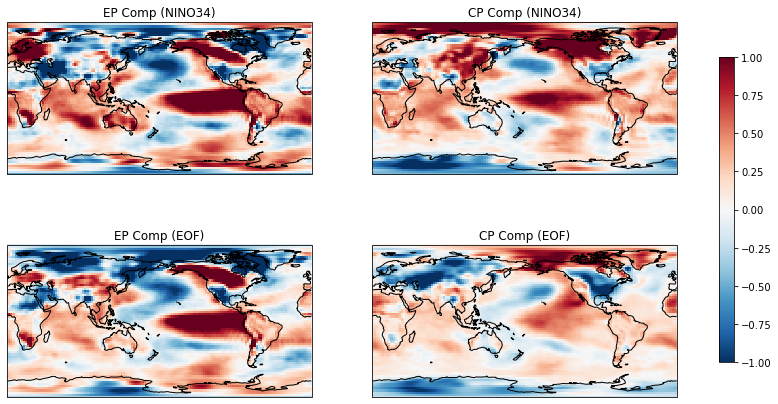

In [19]:
fig = plt.figure(figsize = (15,7.5)) 
axs = []
ax = fig.add_subplot(221, projection=ccrs.PlateCarree(180))
im = ep_comp_ts.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('EP Comp (NINO34)')
axs.append(ax)
ax = fig.add_subplot(222, projection=ccrs.PlateCarree(180))
im = cp_comp_ts.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('CP Comp (NINO34)')
axs.append(ax)
ax = fig.add_subplot(223, projection=ccrs.PlateCarree(180))
im = ep_comp_eof_ts.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('EP Comp (EOF)')
axs.append(ax)
ax = fig.add_subplot(224, projection=ccrs.PlateCarree(180))
im = cp_comp_eof_ts.plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('CP Comp (EOF)')
axs.append(ax)
cbar = plt.colorbar(im, ax=axs, shrink=0.75, pad=0.05)
plt.savefig('ep_cp_comp_nino34_eof_ts_NCEP_NCAR.jpg', bbox_inches='tight', dpi=300)

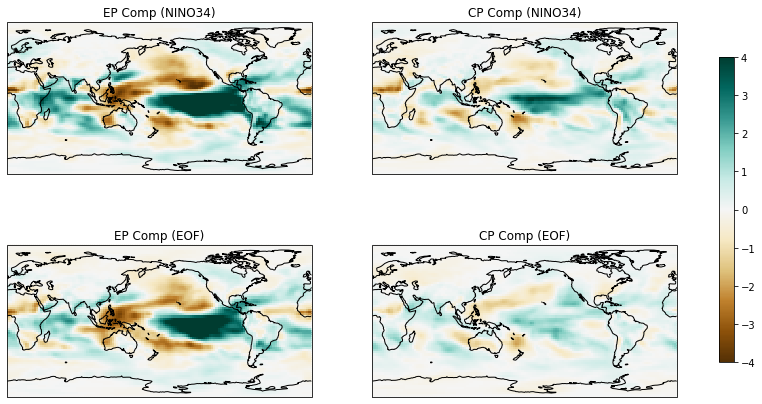

In [20]:
fig = plt.figure(figsize = (15,7.5)) 
axs = []
ax = fig.add_subplot(221, projection=ccrs.PlateCarree(180))
im = ep_comp_pr.plot(ax=ax, vmin=-4, vmax=4, cmap='BrBG', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('EP Comp (NINO34)')
axs.append(ax)
ax = fig.add_subplot(222, projection=ccrs.PlateCarree(180))
im = cp_comp_pr.plot(ax=ax, vmin=-4, vmax=4, cmap='BrBG', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('CP Comp (NINO34)')
axs.append(ax)
ax = fig.add_subplot(223, projection=ccrs.PlateCarree(180))
im = ep_comp_eof_pr.plot(ax=ax, vmin=-4, vmax=4, cmap='BrBG', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('EP Comp (EOF)')
axs.append(ax)
ax = fig.add_subplot(224, projection=ccrs.PlateCarree(180))
im = cp_comp_eof_pr.plot(ax=ax, vmin=-4, vmax=4, cmap='BrBG', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('CP Comp (EOF)')
axs.append(ax)
cbar = plt.colorbar(im, ax=axs, shrink=0.75, pad=0.05)
plt.savefig('ep_cp_comp_nino34_eof_pr_NCEP_NCAR.jpg', bbox_inches='tight', dpi=300)

In [21]:
# Pattern Correlations 
ep_cor_ts = comp_pattern_cor(ep_comp_ts, ep_comp_eof_ts)
cp_cor_ts = comp_pattern_cor(cp_comp_ts, cp_comp_eof_ts)
ep_cor_pr = comp_pattern_cor(ep_comp_pr, ep_comp_eof_pr)
cp_cor_pr = comp_pattern_cor(cp_comp_pr, cp_comp_eof_pr)

In [22]:
print(f'EP Corr ts: {ep_cor_ts[0]}, CP Corr ts: {cp_cor_ts[0]}')
print(f'EP Corr pr: {ep_cor_pr[0]}, CP Corr pr: {cp_cor_pr[0]}')

EP Corr ts: 0.8292937267017373, CP Corr ts: 0.5038777974807223
EP Corr pr: 0.9532378432422486, CP Corr pr: 0.6923811224356432
